In [2]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append('..')
import geo_raster_viewer

In [3]:
# Make our viewer. This has population count for the globe in square kilometer pixels.
viewer = geo_raster_viewer.read_tif("../data/gpw_v4_population_count_rev10_2015_30_sec.tif")

In [ ]:
# If you're interested in a specific region, you can extract it
bhadrak_min_lat = 20.741
bhadrak_max_lat = 21.355
bhadrak_min_lon = 86.130 
bhadrak_max_lon = 86.805

bhadrak = viewer.extract_region(
    bhadrak_min_lat,
    bhadrak_max_lat,
    bhadrak_min_lon,
    bhadrak_max_lon,
)

In [ ]:
# This cell lets the code produce two CSVs that can be used for manifest generation
# clip negative values
bhadrak.pixel_array = np.clip(bhadrak.pixel_array, 0.0, None)

# write population to CSV
bhadrak.pixels_to_file("bhadrak_population")
bhadrak.write_ArcGIS_header("bhadrak_population")

# digitize array, add buffer, and write population density to CSV
categorized_map = bhadrak.digitize([0, 700, np.inf])
periurban_bhadrak = categorized_map.add_categorical_buffer(around=2, distance=5, level=2)
periurban_bhadrak.pixels_to_file("bhadrak_population_density")


In [4]:
# If you're interested in a specific region, you can extract it
test_min_lat = 20.096
test_max_lat = 20.372
test_min_lon = 85.847 
test_max_lon = 86.081

test = viewer.extract_region(
    test_min_lat,
    test_max_lat,
    test_min_lon,
    test_max_lon,
)

In [5]:
# This cell lets the code produce two CSVs that can be used for manifest generation
# clip negative values
test.pixel_array = np.clip(test.pixel_array, 0.0, None)

# write population to CSV
test.pixels_to_file("test_population")
test.write_ArcGIS_header("test_population")

# digitize array, add buffer, and write population density to CSV
categorized_map = test.digitize([0, 700, np.inf])
periurban_test = categorized_map.add_categorical_buffer(around=2, distance=5, level=2)
periurban_test.pixels_to_file("test_population_density")

# create distances array and write to CSV


In [12]:
test_origin_lat = (test_min_lat + test_max_lat) / 2
test_origin_lon = (test_min_lon + test_max_lon) / 2
test_distances = test.get_distances_to_coord([test_origin_lat, test_origin_lon])
np.savetxt("test_distances.csv", test_distances[0], delimiter=" ")

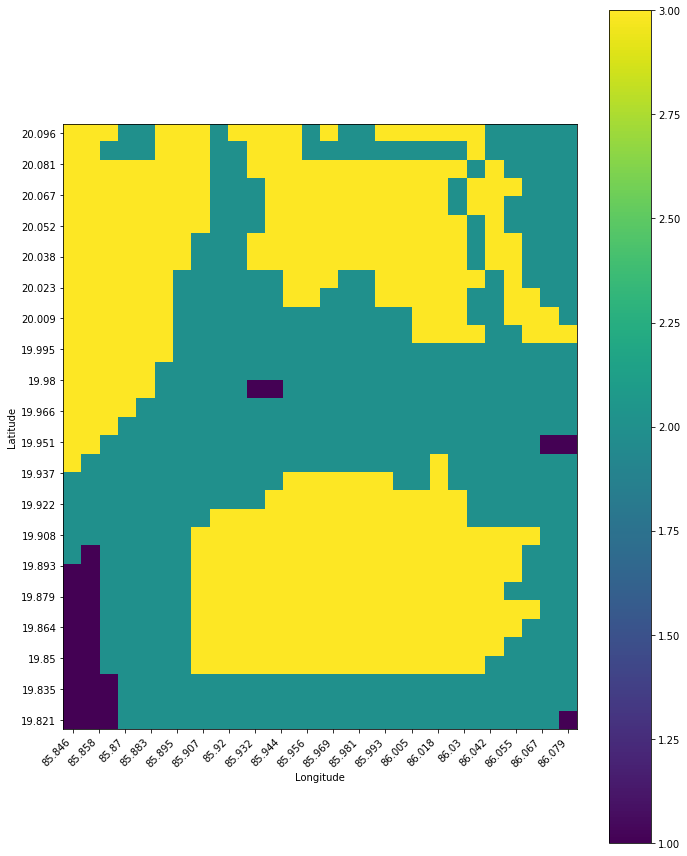

In [5]:
periurban_test.plot()

In [ ]:
pixels = periurban_test.pixel_array
reversed_pixels = pixels[::-1]
tif_filename = "periurban_test.tif"
origin = (85.847, 20.096)
pixel_dimension = 0.00833333333333286
periurban_test.array2raster(tif_filename, origin, pixel_dimension, pixel_dimension, reversed_pixels)

In [ ]:
pixels = periurban_bhadrak.pixel_array
reversed_pixels = pixels[::-1]
tif_filename = "periurban_bhadrak.tif"
origin = (86.05833333331822, 19.691666666662137)
pixel_dimension = 0.00833333333333286
periurban_bhadrak.array2raster(tif_filename, origin, pixel_dimension, pixel_dimension, reversed_pixels)

In [44]:
# Now we do a quick calculation of populations served by each wholesaler and drop the ones without lat/lons.
wholesales = pd.read_csv("wholesale_data_test_region.csv")
wholesales.dropna(subset=['Longitude', 'Latitude'], inplace=True)
wholesales.reset_index(inplace=True)
wholesales_service = []

# Get the list of lat/lons
wholesale_markets = list(zip(wholesales['Latitude'].values, wholesales['Longitude'].values))

# Match pixels to the list of locations
closest_wholesales = test.match_to_closest_location(wholesale_markets)

# We can then get the number of people covered by each location.
people_per_market = test.sum_by_labels(closest_wholesales)
for market_index, people_served in people_per_market.items():
    # print("Wholesale market {} serves: {}".format(wholesales.at[market_index, "Wholesale_Name"], people_served))
    wholesales_service.append(people_served)

# And produce an accessible wholesaler list with the population served data. 
wholesales["Population_Served"] = wholesales_service
wholesales.to_csv("regional_wholesales_test.csv", index=False)

In [49]:
# Now we do a quick calculation of populations served by each village market and drop the ones without lat/lons.
villages = pd.read_csv("test_region_villages.csv")
villages.dropna(subset=['Longitude', 'Latitude'], inplace=True)
villages.reset_index(inplace=True)
villages_service = []

# Get the list of lat/lons
village_markets = list(zip(villages['Latitude'].values, villages['Longitude'].values))

# Match pixels to the list of locations
closest_villages = test.match_to_closest_location(village_markets)

# We can then get the number of people covered by each location.
people_per_market = test.sum_by_labels(closest_villages)
for market_index, people_served in people_per_market.items():
    # print("Village market {} serves: {}".format(villages.at[market_index, "Village"], people_served))
    villages_service.append(people_served)
    
# And produce an accessible village market list with the population served data. 
villages["Population_Served"] = villages_service
villages.to_csv("regional_village_service_test.csv", index=False)